# <span style="color:darkorange">Energy Consumption Optimizer</span>


## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.9 or later is installed (ideally I would generatlly recommend Python 3.10), as well as Scikit-Learn ≥ 1.0

In [2]:
# Python ≥3.9 is required
import sys
assert sys.version_info >= (3, 9)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Precision options
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.3f}'.format

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#### 1. Get the data

In [3]:
# Load dataset
df = pd.read_csv("household_power_consumption.txt", sep=';', low_memory=False)

### Take a quick look at the data

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


In [5]:
df.shape

(2075259, 9)

In [6]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [7]:
df.describe()

,Sub_metering_3
count,2049280.000
mean,6.458
std,8.437
min,0.000
25%,0.000
50%,1.000
75%,17.000
max,31.000


In [8]:
print(df.dtypes)

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object


Here teh type of coulmns are object, so when using "df.describe" we can not have statistical information about the data wont

In [9]:
num_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [10]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280.000,2049280.000,2049280.000,2049280.000,2049280.000,2049280.000,2049280.000
mean,1.092,0.124,240.840,4.628,1.122,1.299,6.458
std,1.057,0.113,3.240,4.444,6.153,5.822,8.437
min,0.076,0.000,223.200,0.200,0.000,0.000,0.000
25%,0.308,0.048,238.990,1.400,0.000,0.000,0.000
50%,0.602,0.100,241.010,2.600,0.000,0.000,1.000
75%,1.528,0.194,242.890,6.400,0.000,1.000,17.000
max,11.122,1.390,254.150,48.400,88.000,80.000,31.000


## About the datast
⚡ UCI Household Electric Power Consumption Dataset (Simplified)

This dataset records how much electricity one household in France consumed over 4 years (2006–2010).
It has minute-by-minute measurements.


#### Description of the features:

Here follows a detailed description of all the features (i.e. columns/variables) in the dataset:

1. **date:** Date in format dd/mm/yyyy 
2. **time:** time in format hh:mm:ss
3. **global_active_power:** household global minute-averaged active power (in kilowatt). The main electricity the household actually used.
Think of it as “how much power the whole house is consuming right now.” Higher values = more devices running.
4. **global_reactive_power:** household global minute-averaged reactive power (in kilowatt). Power that doesn’t do useful work (wasted or stored temporarily). 
5. **voltage:** minute-averaged voltage (in volt). The electric pressure in the house
6. **global_intensity:** household global minute-averaged current intensity (in ampere)
7. **sub_metering_1:** energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the **kitchen**, containing mainly a **dishwasher**, an **oven** and **a microwave** (hot plates are not electric but gas powered).
8. **sub_metering_2:** energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the **laundry room**, containing a **washing-machine**, **a tumble-drier**, **a refrigerator** and **a light**.
9. **sub_metering_3:** energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an **electric water-heater and an air-conditioner**.

These features include a mix of **numerical** (e.g., `sub_metering`) and **Time** and **Date** variables. Understanding each feature’s role will help in preprocessing, feature engineering, and model selection.


## Business Proplem

*Energy is expensive and limited. Many households, offices, and factories consume energy inefficiently — using appliances during peak hours or keeping devices on unnecessarily. An optimizer can help reduce costs and carbon footprint by analyzing consumption patterns and suggesting smarter usage.*

In [11]:
# make copy form the dataset
df_copy = df.copy()

## Exploratory Data Analysis

In [12]:
df.isnull().sum() # total rows is 2075259

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

## 2. Discover and Visualize the Data to Gain Insights

### 2.1 Outlier Detection

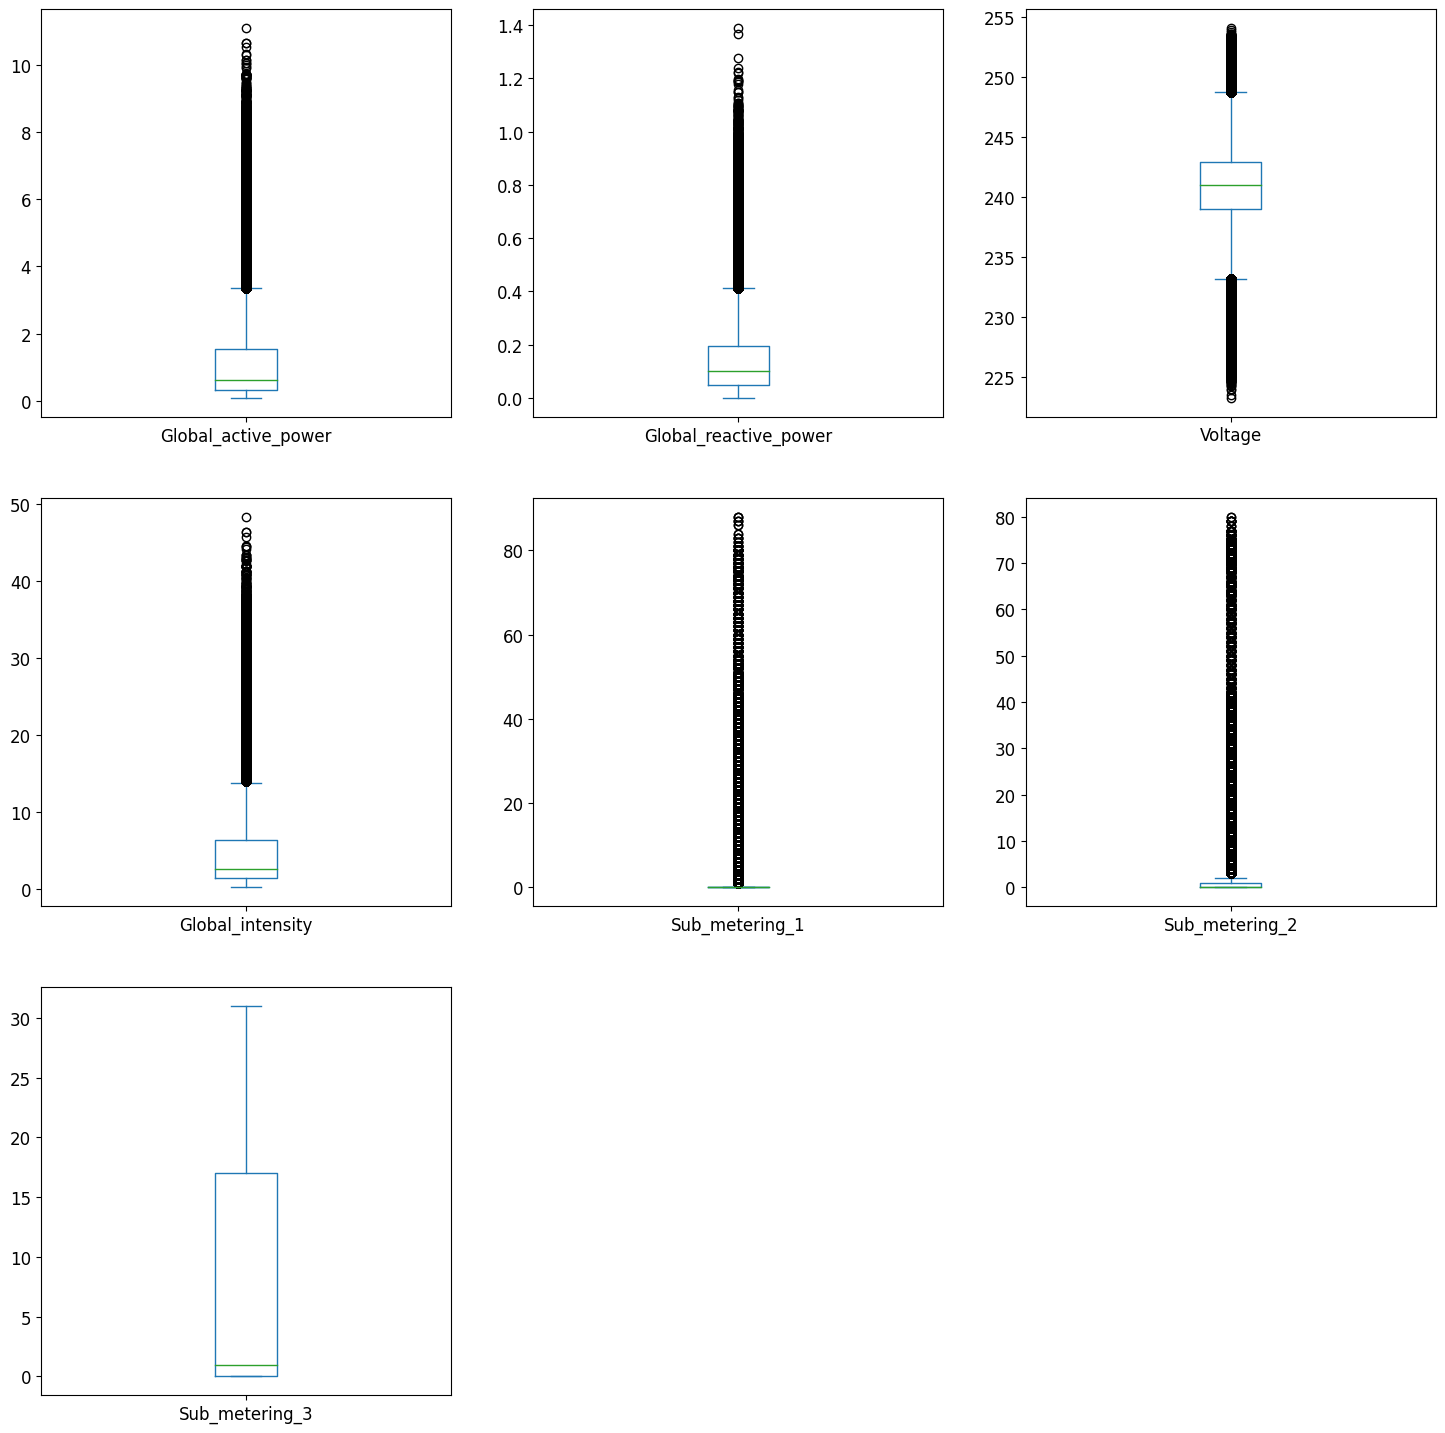

In [13]:
p = df[
    ["Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"]
].plot.box(subplots=True, layout=(3, 3), figsize=(18,18))

### 2.3 Numerical features: looking for correlations

In [14]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000,0.247,-0.400,0.999,0.484,0.435,0.639
Global_reactive_power,0.247,1.000,-0.112,0.266,0.123,0.139,0.090
Voltage,-0.400,-0.112,1.000,-0.411,-0.196,-0.167,-0.268
Global_intensity,0.999,0.266,-0.411,1.000,0.489,0.440,0.627
Sub_metering_1,0.484,0.123,-0.196,0.489,1.000,0.055,0.103
Sub_metering_2,0.435,0.139,-0.167,0.440,0.055,1.000,0.081
Sub_metering_3,0.639,0.090,-0.268,0.627,0.103,0.081,1.000


### Check for multicolinearity

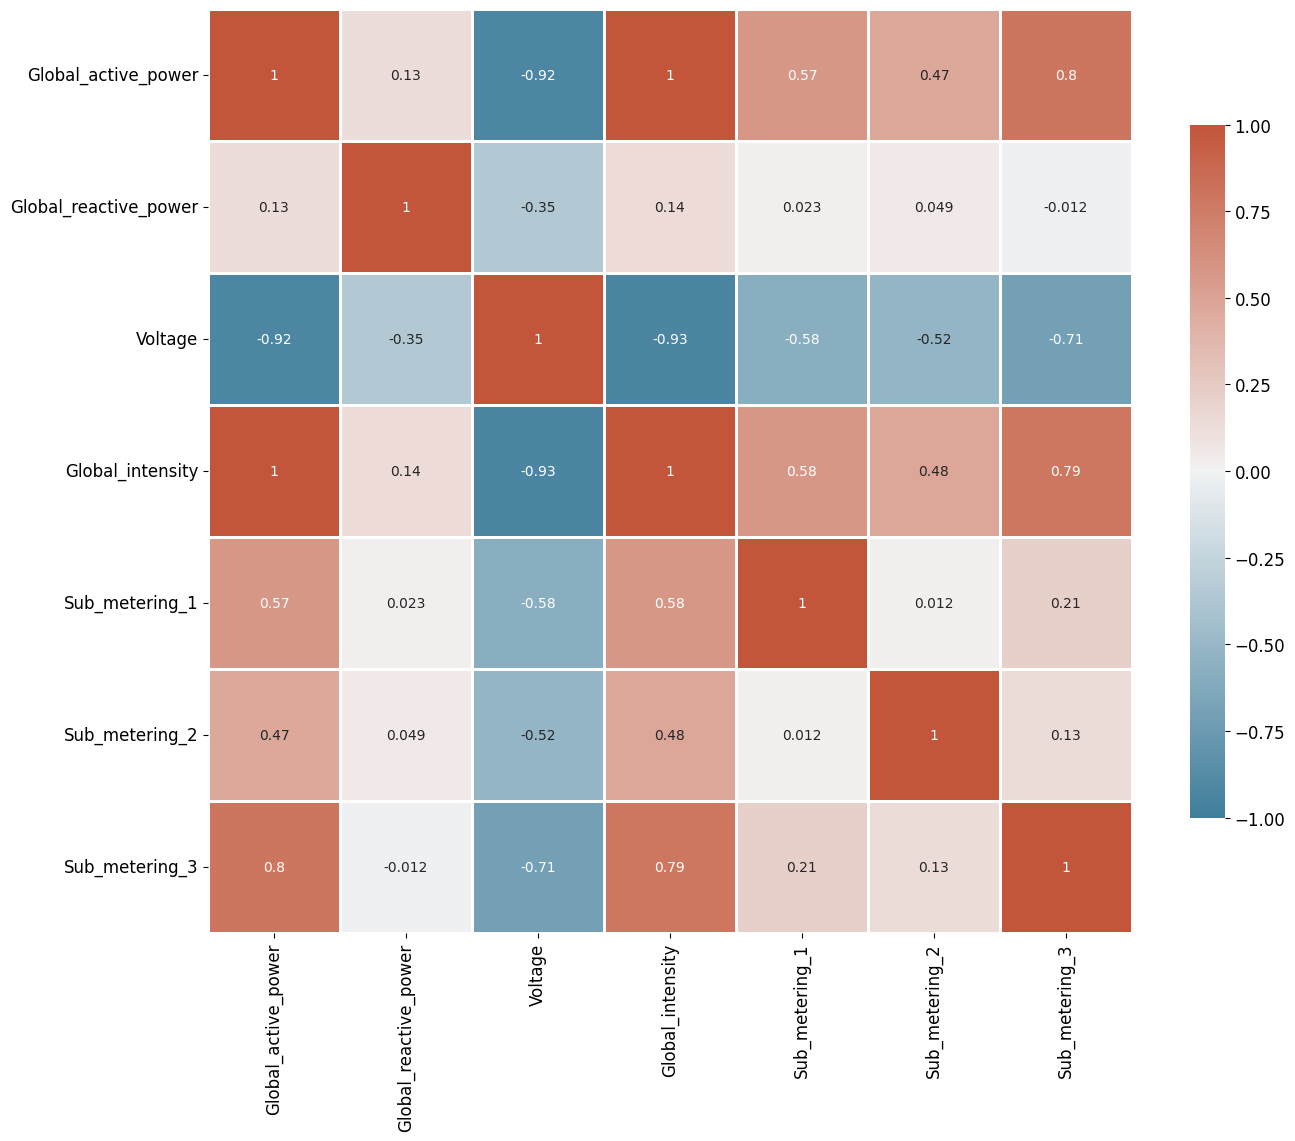

In [15]:
# check for multicolinearity with seaborn heatmap
# compute the correlation matrix
corr = round(corr_matrix.corr(numeric_only=True), 3)

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 12))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=1, cbar_kws={"shrink": .75}, annot=True)

plt.show()

We can now draw some conclusions. If we use 0.65 as a cutoff, we can clearly see that there is high correlation between `global_active_power` and `sub_metering_3`, `global_active_power` and `voltage`also between `voltage` and `global_intensity`, between `global_intensity`and `sub_metering_3` . Ideally we need to deal with multicolinearity in our features and retain those variabe that corelate more with predicted variable.

###  Visulize the data 

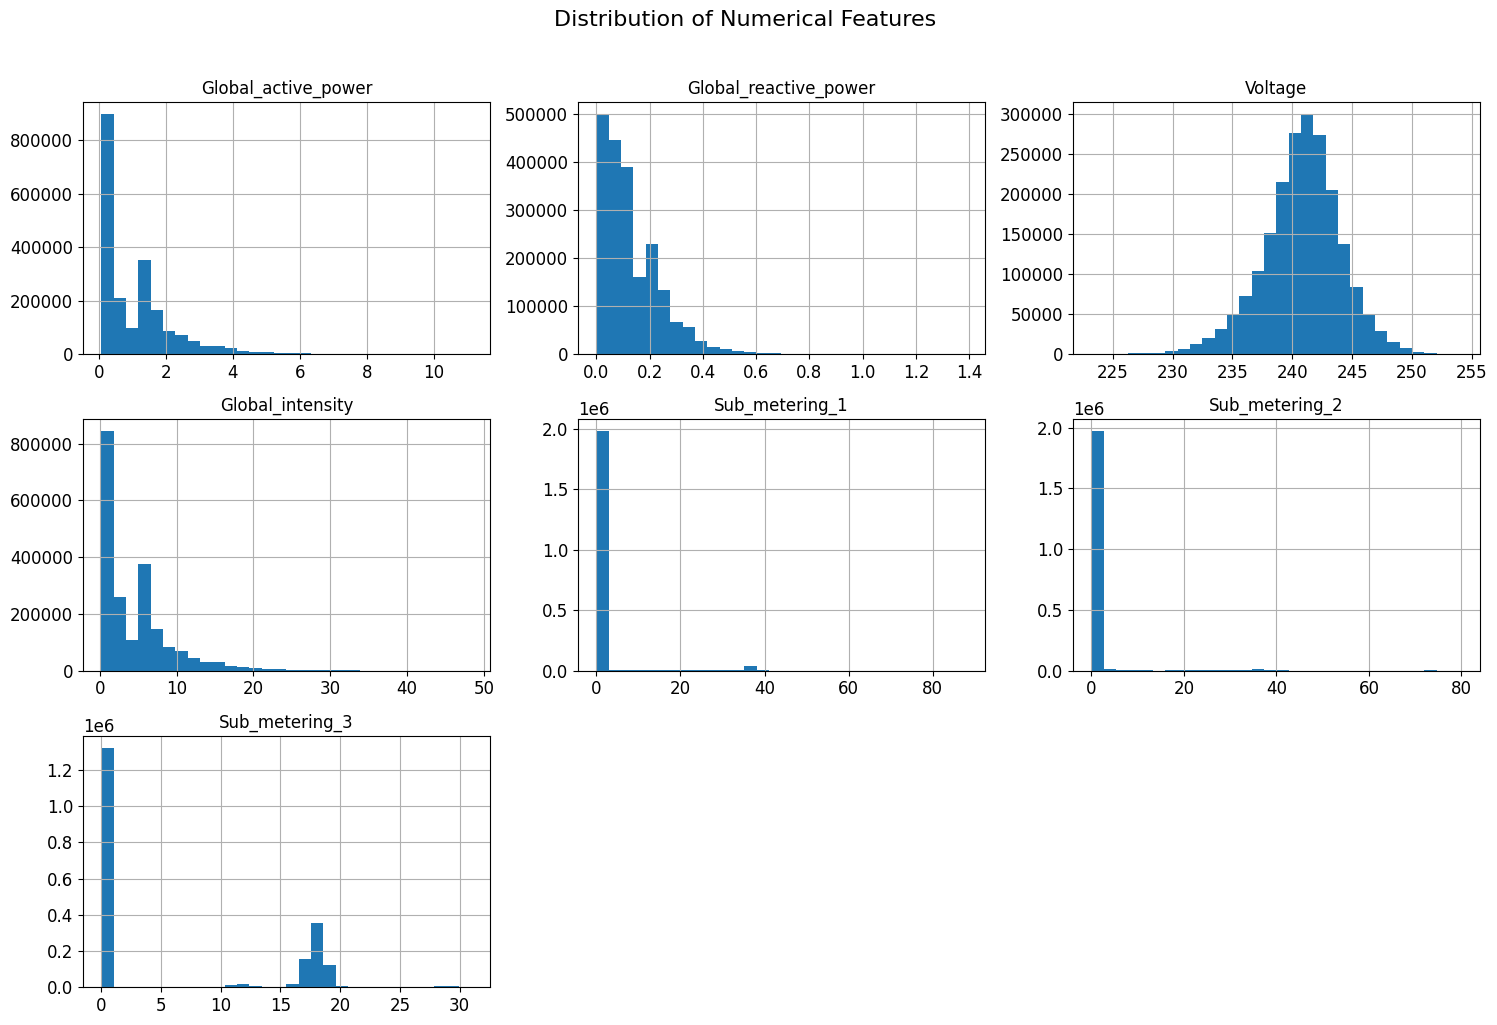

In [16]:
df[[
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]].hist(bins=30, figsize=(15, 10))

plt.suptitle("Distribution of Numerical Features", fontsize=16, y=1.02)  # move title up
plt.tight_layout()
plt.show()


In [17]:
# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [18]:
# Fill in missing values to visulaize the data 
# use df_copy

def fill_in_missing_values(df):
    # Handle Missing Values Based on Skewness
    for col in ["Global_active_power","Global_reactive_power","Voltage","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]:
        skewness = df[col].skew()  # Check skewness
        if skewness > 0:  # Positively skewed
            df[col].fillna(df[col].median(), inplace=True)
        else:  # Normal or negative skew
            df[col].fillna(df[col].mean(), inplace=True)
      
    return df

In [19]:
fill_in_missing_values(df_copy)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.000
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.000
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.000
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.000


In [20]:
df_copy.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

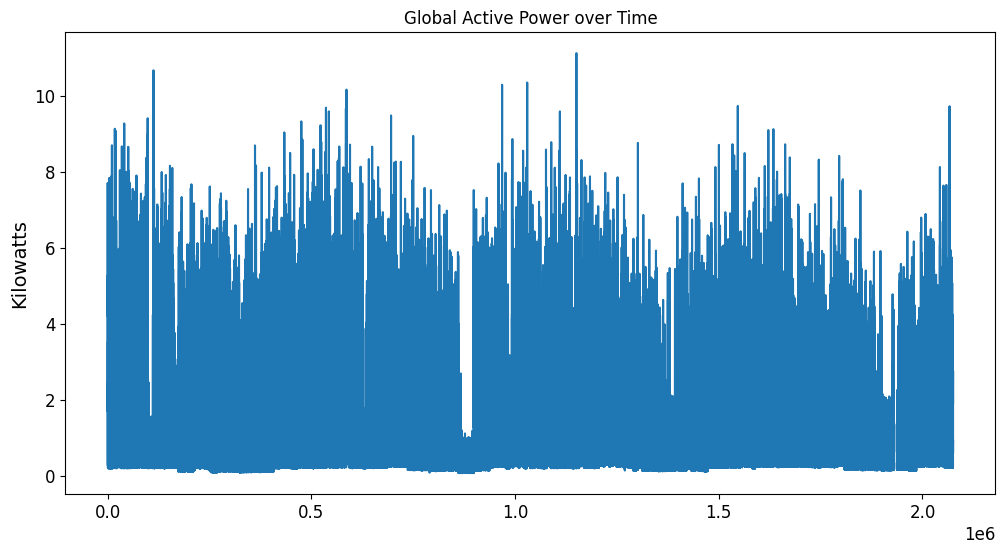

In [21]:
df_copy["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df_copy.set_index("Datetime", inplace=True)


df["Global_active_power"].plot(figsize=(12,6))
plt.title("Global Active Power over Time")
plt.ylabel("Kilowatts")
plt.show()

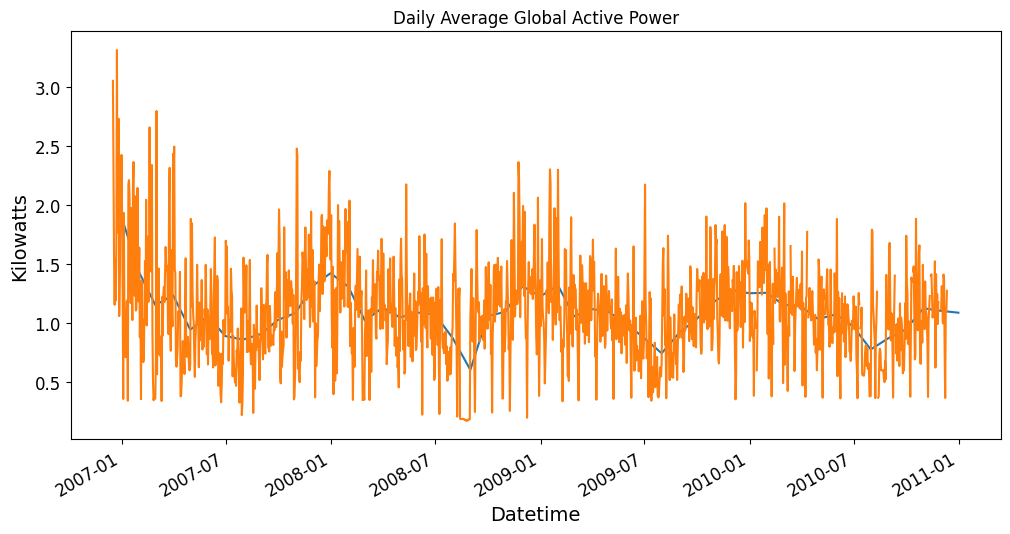

In [86]:
sns.lineplot(data=df_copy["Global_active_power"].resample("m").mean())
daily.plot(figsize=(12,6))
plt.title("Daily Average Global Active Power")
plt.ylabel("Kilowatts")
plt.show()

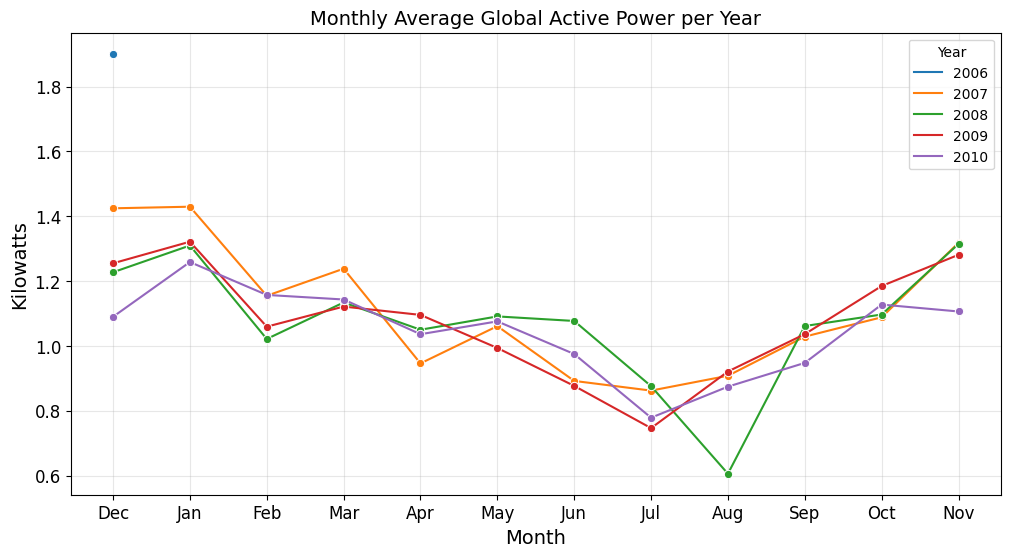

In [23]:
# Extract year and month
df_copy["year"] = df_copy.index.year
df_copy["month"] = df_copy.index.month

# Aggregate by year & month
monthly = df_copy.groupby(["year", "month"])["Global_active_power"].mean().reset_index()

# Turn month numbers into names
import calendar
monthly["month_name"] = monthly["month"].apply(lambda x: calendar.month_abbr[x])

# Lineplot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly,
    x="month_name", 
    y="Global_active_power",
    hue="year",
    marker="o",
    palette="tab10"
)

plt.title("Monthly Average Global Active Power per Year", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Kilowatts")
plt.legend(title="Year")
plt.grid(alpha=0.3)
plt.show()


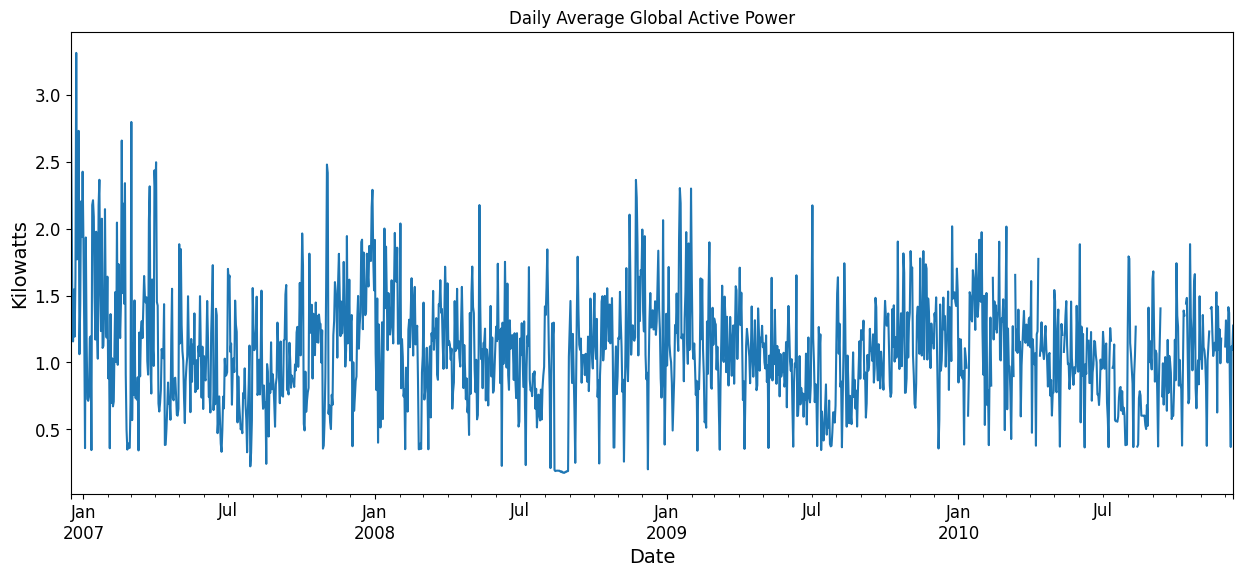

In [24]:
# Resample by day
daily = df_copy["Global_active_power"].resample("D").mean()

plt.figure(figsize=(15,6))
daily.plot()
plt.title("Daily Average Global Active Power")
plt.ylabel("Kilowatts")
plt.xlabel("Date")
plt.show()

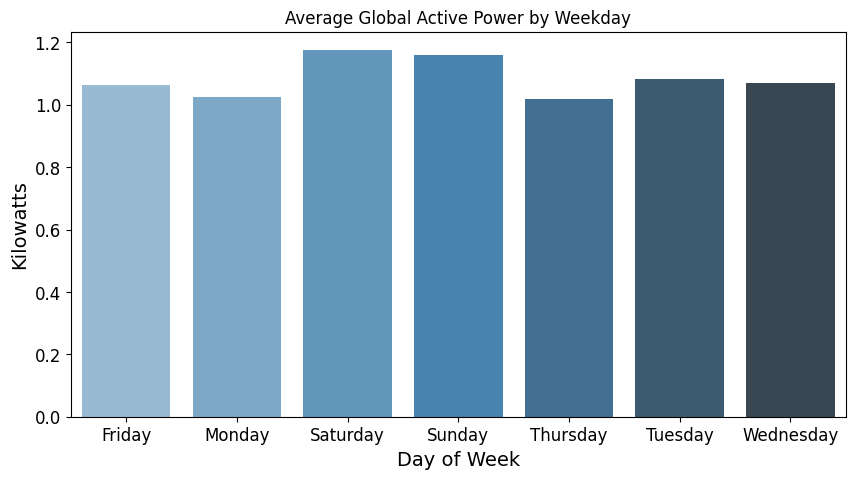

In [25]:
# Add weekday (Mon=0, Sun=6)
df_copy["weekday"] = df_copy.index.day_name()

# Average by weekday
weekly = df_copy.groupby("weekday")["Global_active_power"].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=weekly.index, y=weekly.values, palette="Blues_d")
plt.title("Average Global Active Power by Weekday")
plt.ylabel("Kilowatts")
plt.xlabel("Day of Week")
plt.show()

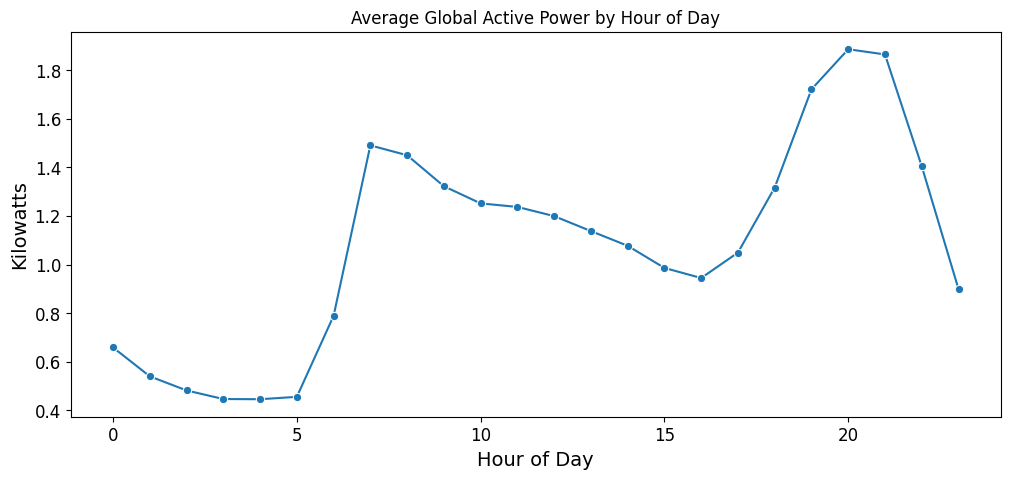

In [26]:
# Add hour column
df_copy["hour"] = df_copy.index.hour

# Average by hour
hourly = df_copy.groupby("hour")["Global_active_power"].mean()

plt.figure(figsize=(12,5))
sns.lineplot(x=hourly.index, y=hourly.values, marker="o")
plt.title("Average Global Active Power by Hour of Day")
plt.ylabel("Kilowatts")
plt.xlabel("Hour of Day")
plt.show()

#### Compare between sub_metering 1,2,3. whcih one is the main drive?

C:\Users\nuhaa\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


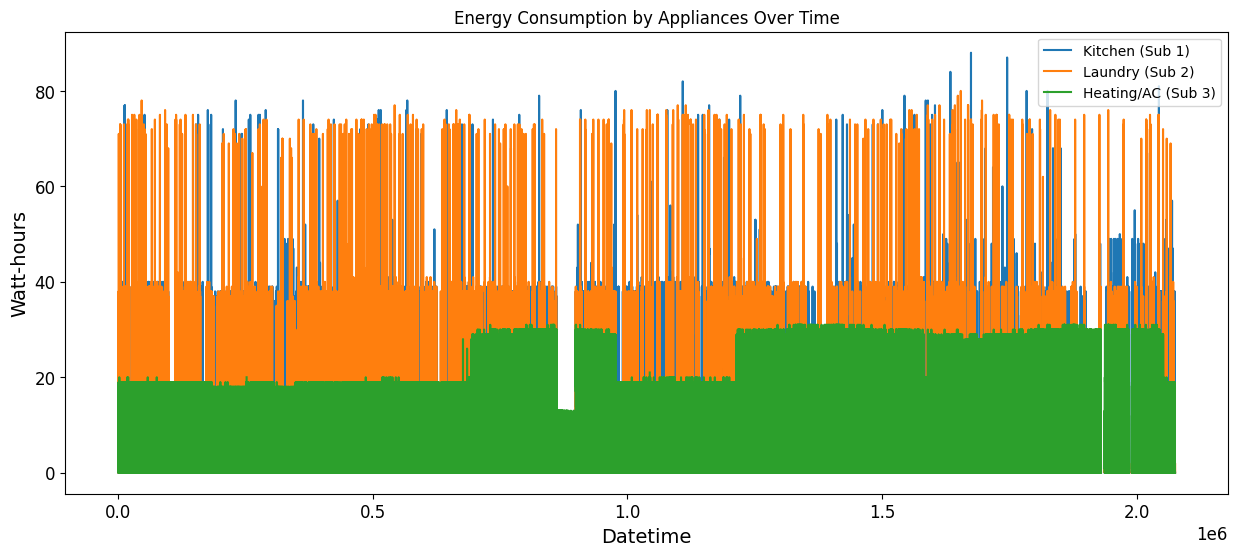

In [27]:
plt.figure(figsize=(15,6))

plt.plot(df.index, df["Sub_metering_1"], label="Kitchen (Sub 1)")
plt.plot(df.index, df["Sub_metering_2"], label="Laundry (Sub 2)")
plt.plot(df.index, df["Sub_metering_3"], label="Heating/AC (Sub 3)")

plt.title("Energy Consumption by Appliances Over Time")
plt.xlabel("Datetime")
plt.ylabel("Watt-hours")
plt.legend()
plt.show()


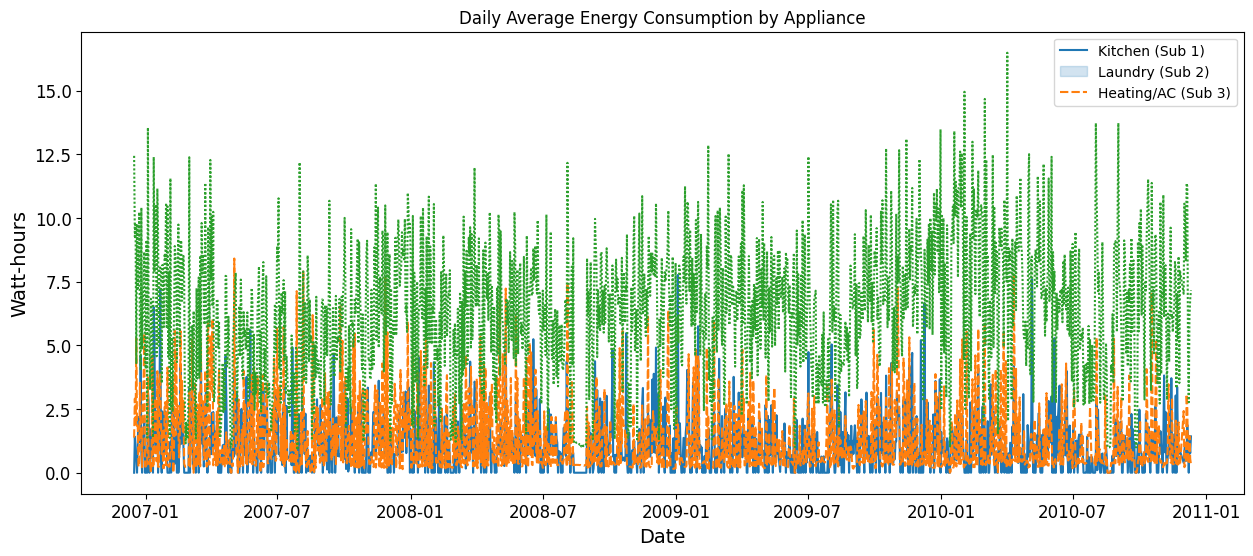

In [28]:
daily_sub = df_copy[["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].resample("D").mean()

plt.figure(figsize=(15,6))
sns.lineplot(data=daily_sub)
plt.title("Daily Average Energy Consumption by Appliance")
plt.ylabel("Watt-hours")
plt.xlabel("Date")
plt.legend(labels=["Kitchen (Sub 1)", "Laundry (Sub 2)", "Heating/AC (Sub 3)"])
plt.show()


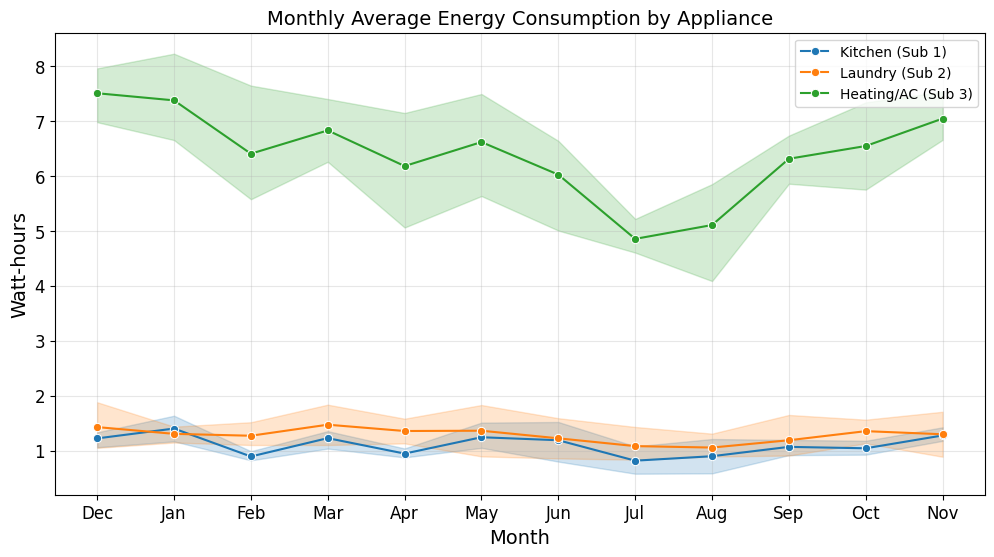

In [29]:
# Extract year and month
df_copy["year"] = df_copy.index.year
df_copy["month"] = df_copy.index.month

# Aggregate by year+month
monthly = df_copy.groupby(["year", "month"])[
    ["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
].mean().reset_index()

# Turn month numbers into names
import calendar
monthly["month_name"] = monthly["month"].apply(lambda x: calendar.month_abbr[x])

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x="month_name", y="Sub_metering_1", label="Kitchen (Sub 1)", marker="o")
sns.lineplot(data=monthly, x="month_name", y="Sub_metering_2", label="Laundry (Sub 2)", marker="o")
sns.lineplot(data=monthly, x="month_name", y="Sub_metering_3", label="Heating/AC (Sub 3)", marker="o")

plt.title("Monthly Average Energy Consumption by Appliance", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Watt-hours")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


C:\Users\nuhaa\AppData\Local\Temp\ipykernel_33928\3060707554.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  one_month = df_copy["2010-01"]


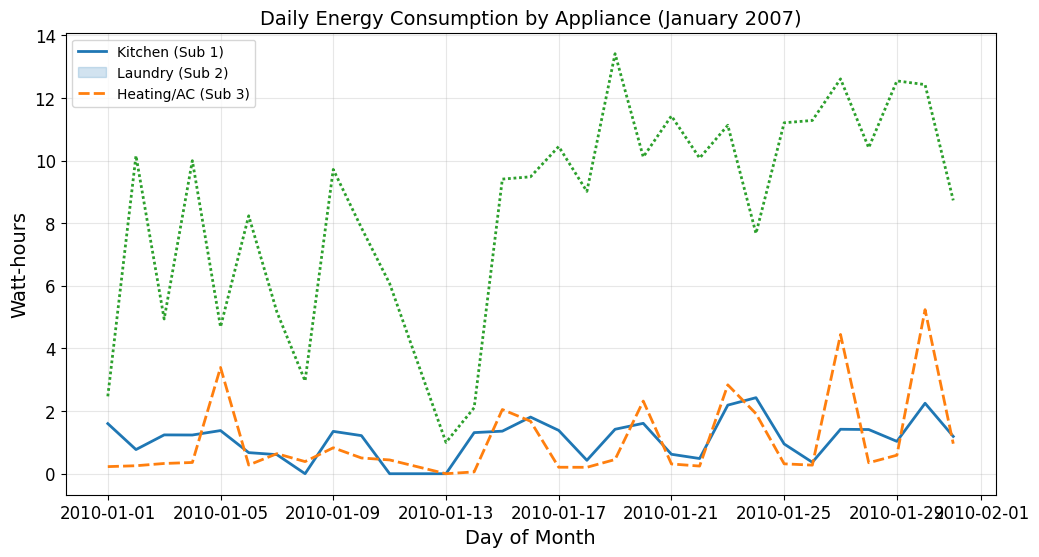

In [30]:
# Filter for one month (January 2007 for example)
one_month = df_copy["2010-01"]

# Resample daily to see day-to-day variation
daily_month = one_month[["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].resample("D").mean()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_month, linewidth=2.0)

plt.title("Daily Energy Consumption by Appliance (January 2007)", fontsize=14)
plt.xlabel("Day of Month")
plt.ylabel("Watt-hours")
plt.legend(labels=["Kitchen (Sub 1)", "Laundry (Sub 2)", "Heating/AC (Sub 3)"])
plt.grid(alpha=0.3)
plt.show()


C:\Users\nuhaa\AppData\Local\Temp\ipykernel_33928\2050033885.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  one_day = df_copy["2010-03-01"]


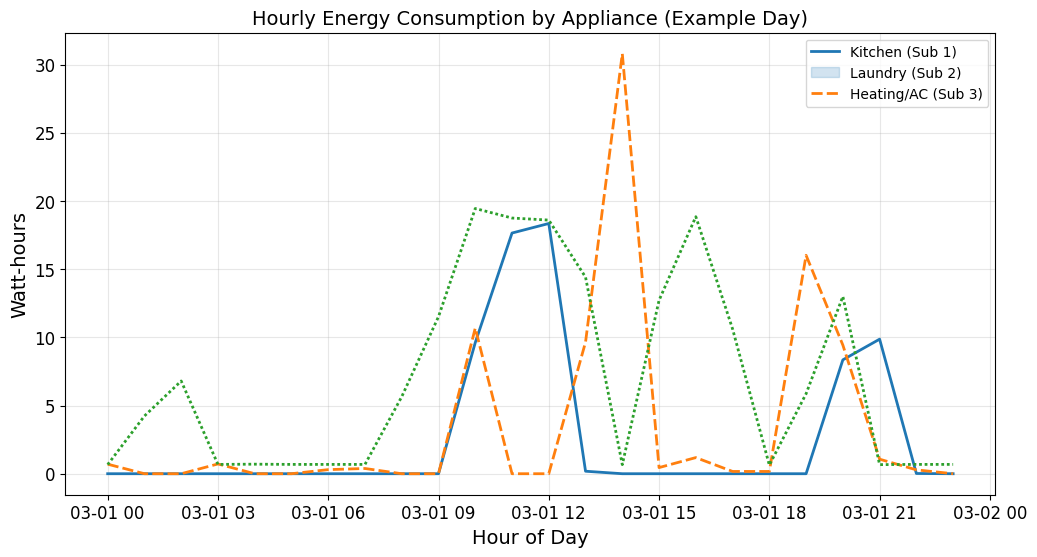

In [31]:
# Pick one day 
one_day = df_copy["2010-03-01"]

# Resample hourly to smooth
hourly_day = one_day[["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].resample("H").mean()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_day, linewidth=2.0)

plt.title("Hourly Energy Consumption by Appliance (Example Day)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Watt-hours")
plt.legend(labels=["Kitchen (Sub 1)", "Laundry (Sub 2)", "Heating/AC (Sub 3)"])
plt.grid(alpha=0.3)
plt.show()


## Conclusion of EDA

At the end of our exploratory analysis, we have reached the following conclusions:

### Seasonal / Yearly Patterns
- Consumption rises from December → January (peaks in winter months).
- Lowest consumption in July → August (summer).
- Pattern is consistent across all five years.
- Consumption relatively stable year-to-year, except for small variations (e.g., 2008 August drop).
- 2007 December and January have slightly higher consumption.

### Daily / Weekly Patterns
- Weekends: higher consumption than weekdays.
- Weekdays: lower consumption, especially during the day.
- Night peak: 6–9 PM → likely cooking, lighting, heating.
- Morning peak: noticeable but lower than evening peak → breakfast usage.
- Pattern is consistent across all five years.

### Appliance / Submeter Analysis
- **Sub_metering_3 (Heating/AC)** → main energy driver; highest in Nov, Dec, Jan; lowest in Jul, Aug.
- **Sub_metering_2 (Laundry)** → second driver, relatively consistent year-round.
- **Sub_metering_1 (Kitchen)** → third driver, peaks in January, lower in summer months.

### Interpretation
- Household energy usage is highest in winter, driven mainly by heating.
- Evening consumption dominates daily patterns, aligning with typical household routines.
- Seasonal and daily patterns are predictable and repeatable, useful for:
  - Forecasting energy demand
  - Designing energy-saving strategies
  - Deploying optimization models

### Key EDA Findings (for Data Preparation)
1. **Variable Types:** Quantitative, date, and time variables identified.
2. **Missing Values:** 25,979 records missing in `Global_active_power`, `Global_reactive_power`, `Voltage`, `Global_intensity`, `Sub_metering_1`, `Sub_metering_2`, `Sub_metering_3` — require imputation.
3. **Duplicate Rows:** Non detected.
4. **Outliers:** None detected.
5. **Data Skewness:** `Voltage` ~ normal; other features skewed → transformation recommended for normality.
6. **Scaling:** Necessary for numerical features due to differing scales.
7. **Encoding:** Not required.
8. **Multicollinearity:** Present between:
   - `Global_active_power` & `Sub_metering_3`
   - `Global_active_power` & `Voltage`
   - `Voltage` & `Global_intensity`
   - `Global_intensity` & `Sub_metering_3`
   - **Action:** retain features most correlated with predicted variable.


# Data Preparation

### Dealing with missing values

In [32]:
data = df.copy()
fill_in_missing_values(data)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.000
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.000
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.000
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.000


In [33]:
data.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Dealing with multicolinearity

Check VIF (Variance Inflation Factor) is a strong test for multicolinearity 

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_num = data.select_dtypes(include=['float64','int64'])

vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
print(vif_data)


                 feature      VIF
0    Global_active_power 1271.006
1  Global_reactive_power    2.898
2                Voltage    3.067
3       Global_intensity 1276.514
4         Sub_metering_1    1.662
5         Sub_metering_2    1.570
6         Sub_metering_3    3.628


#### Rule of Thumb for VIF

VIF < 5 → Safe, no multicollinearity issue.

5 ≤ VIF < 10 → Moderate, keep an eye but may not require removal.

VIF ≥ 10 → Strong, needs action (drop or transform).

**Global_active_power** (1271.006) and **Global_intensity** (1276.514) are problematic. They’re highly correlated with each other.

In [35]:
# Drop Global_intensity form the data, keep Global_reactive-power since it will be more informative to the model
data = data.drop(columns=['Global_intensity'])

In [36]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,0.000,1.000,17.000


Recheck after removing reduandant information

In [37]:
X_num = data.select_dtypes(include=['float64','int64'])

vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
print(vif_data)


                 feature   VIF
0    Global_active_power 7.572
1  Global_reactive_power 2.378
2                Voltage 3.061
3         Sub_metering_1 1.652
4         Sub_metering_2 1.559
5         Sub_metering_3 3.438


## Feature Engineering

In [38]:
data["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
data.set_index("Datetime", inplace=True)

In [39]:
def feature_engineering_fun(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

    # Lag features/ Use the past value of a variable as a new feature to help predict the future
    # past consumption shifted forward in time, so the model can use yesterday/hour-ago behavior to predict today/next hour.
    df['lag_1h'] = df['Global_active_power'].shift(1)
    df['lag_24h'] = df['Global_active_power'].shift(24)

    # Rolling features/ What has the average (or sum, min, max, etc.) of the last few time steps been?”
    # It smooths short-term fluctuations and captures trends.
    df['rolling_mean_24h'] = df['Global_active_power'].rolling(24).mean()
    df['rolling_std_24h'] = df['Global_active_power'].rolling(24).std()

    # Ratios
    df['sub_metering_total'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
    df['kitchen_ratio'] = df['Sub_metering_1'] / (df['sub_metering_total'] + 1e-6)
    df['heating_ratio'] = df['Sub_metering_3'] / (df['sub_metering_total'] + 1e-6)

    return df

In [40]:
feature_engineering_fun(data)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,is_weekend,lag_1h,lag_24h,rolling_mean_24h,rolling_std_24h,sub_metering_total,kitchen_ratio,heating_ratio
Datetime,,,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.840,0.000,1.000,17.000,17,5,12,1,NaN,NaN,NaN,NaN,18.000,0.000,0.944
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.630,0.000,1.000,16.000,17,5,12,1,4.216,NaN,NaN,NaN,17.000,0.000,0.941
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.290,0.000,2.000,17.000,17,5,12,1,5.360,NaN,NaN,NaN,19.000,0.000,0.895
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.740,0.000,1.000,17.000,17,5,12,1,5.374,NaN,NaN,NaN,18.000,0.000,0.944
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.680,0.000,1.000,17.000,17,5,12,1,5.388,NaN,NaN,NaN,18.000,0.000,0.944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,26/11/2010,20:58:00,0.946,0.000,240.430,0.000,0.000,0.000,20,4,11,0,0.946,0.968,0.970,0.056,0.000,0.000,0.000
2010-11-26 20:59:00,26/11/2010,20:59:00,0.944,0.000,240.000,0.000,0.000,0.000,20,4,11,0,0.946,0.960,0.970,0.056,0.000,0.000,0.000
2010-11-26 21:00:00,26/11/2010,21:00:00,0.938,0.000,239.820,0.000,0.000,0.000,21,4,11,0,0.944,0.964,0.969,0.057,0.000,0.000,0.000


Now we have 19 columns in our dataset

### 4.2.1 Check there are no missing values in the engineered dataset

In [41]:
## Look for rows with incomplete values
incomplete_rows = data[data.isna().any(axis=1)]
incomplete_rows.isnull().sum()

Date                      0
Time                      0
Global_active_power       0
Global_reactive_power     0
Voltage                   0
Sub_metering_1            0
Sub_metering_2            0
Sub_metering_3            0
hour                      0
dayofweek                 0
month                     0
is_weekend                0
lag_1h                    1
lag_24h                  24
rolling_mean_24h         23
rolling_std_24h          23
sub_metering_total        0
kitchen_ratio             0
heating_ratio             0
dtype: int64

In [42]:
data = data.dropna()

In [43]:
incomplete_rows = data[data.isna().any(axis=1)]
incomplete_rows.isnull().sum()

Date                    0.000
Time                    0.000
Global_active_power     0.000
Global_reactive_power   0.000
Voltage                 0.000
Sub_metering_1          0.000
Sub_metering_2          0.000
Sub_metering_3          0.000
hour                    0.000
dayofweek               0.000
month                   0.000
is_weekend              0.000
lag_1h                  0.000
lag_24h                 0.000
rolling_mean_24h        0.000
rolling_std_24h         0.000
sub_metering_total      0.000
kitchen_ratio           0.000
heating_ratio           0.000
dtype: float64

In [44]:

# Cyclical encoding for hour of day
data["hour_sin"] = np.sin(2 * np.pi * data["hour"]/24)
data["hour_cos"] = np.cos(2 * np.pi * data["hour"]/24)

# Cyclical encoding for day of week
data["dayofweek_sin"] = np.sin(2 * np.pi * data["dayofweek"]/7)
data["dayofweek_cos"] = np.cos(2 * np.pi * data["dayofweek"]/7)

# Cyclical encoding for month
data["month_sin"] = np.sin(2 * np.pi * data["month"]/12)
data["month_cos"] = np.cos(2 * np.pi * data["month"]/12)


C:\Users\nuhaa\AppData\Local\Temp\ipykernel_33928\596497505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["hour_sin"] = np.sin(2 * np.pi * data["hour"]/24)
C:\Users\nuhaa\AppData\Local\Temp\ipykernel_33928\596497505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["hour_cos"] = np.cos(2 * np.pi * data["hour"]/24)
C:\Users\nuhaa\AppData\Local\Temp\ipykernel_33928\596497505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [45]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,...,rolling_std_24h,sub_metering_total,kitchen_ratio,heating_ratio,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:48:00,16/12/2006,17:48:00,4.474,0.000,234.960,0.000,0.000,17.000,17,5,...,1.211,17.000,0.000,1.000,-0.966,-0.259,-0.975,-0.223,-0.000,1.000
2006-12-16 17:49:00,16/12/2006,17:49:00,3.248,0.000,236.660,0.000,0.000,17.000,17,5,...,1.228,17.000,0.000,1.000,-0.966,-0.259,-0.975,-0.223,-0.000,1.000
2006-12-16 17:50:00,16/12/2006,17:50:00,3.236,0.000,235.840,0.000,0.000,17.000,17,5,...,1.238,17.000,0.000,1.000,-0.966,-0.259,-0.975,-0.223,-0.000,1.000
2006-12-16 17:51:00,16/12/2006,17:51:00,3.228,0.000,235.600,0.000,0.000,17.000,17,5,...,1.242,17.000,0.000,1.000,-0.966,-0.259,-0.975,-0.223,-0.000,1.000
2006-12-16 17:52:00,16/12/2006,17:52:00,3.258,0.000,235.490,0.000,0.000,17.000,17,5,...,1.253,17.000,0.000,1.000,-0.966,-0.259,-0.975,-0.223,-0.000,1.000


## Split data into train set and test set

In [46]:
# Define Global_active_power as target varaiable 
X = data.drop("Global_active_power", axis=1)
y = data["Global_active_power"]

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffle for time series
)


## Feature Scaling

In [48]:
numerical_features = [
    "Global_reactive_power",
    "Voltage", "Sub_metering_1",
    "Sub_metering_2", "Sub_metering_3",           
    "lag_1h", "lag_24h",                 
    "rolling_mean_24h" , "rolling_std_24h",         
    "sub_metering_total" , "kitchen_ratio",          
    "heating_ratio"]

We use a separate scaler for the target. That way, you can train your model on the scaled values, and later inverse-transform predictions back to the original scale for interpretation.

In [49]:
from sklearn.preprocessing import StandardScaler

# Scale X (features) 
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train[numerical_features])
X_test_scaled = scaler_X.transform(X_test[numerical_features])

# Scale y (target) 
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

In [50]:
# Concatenate time featuers with scaled featuers
# We drop date and time faetuers, we already extratced hour, dayofweek, month and is_weekend
# ML models don’t understand raw timestamps.
time_features = [                
    "hour_sin",
    "hour_cos",                   
    "dayofweek_sin", 
    "dayofweek_cos",              
    "month_sin", 
    "month_cos",  
    "is_weekend" ]

In [51]:
# Convert scaled arrays back into DataFrames with correct column names and index
X_train_scaled_df = pd.DataFrame(
    X_train_scaled, 
    columns=numerical_features, 
    index=X_train.index
)

X_test_scaled_df = pd.DataFrame(
    X_test_scaled, 
    columns=numerical_features, 
    index=X_test.index
)


# Concatenate scaled numerical features with time features
# Reset index for both scaled and time features before concatenation
X_train_final = pd.concat([
    X_train_scaled_df.reset_index(drop=True), 
    X_train[time_features].reset_index(drop=True)
], axis=1)

X_test_final = pd.concat([
    X_test_scaled_df.reset_index(drop=True), 
    X_test[time_features].reset_index(drop=True)
], axis=1)


In [52]:
X_train_final.head()

,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,lag_1h,lag_24h,rolling_mean_24h,rolling_std_24h,sub_metering_total,kitchen_ratio,heating_ratio,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,is_weekend
0,-1.091,-1.731,-0.184,-0.224,1.272,3.728,2.849,3.475,2.635,0.626,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1
1,-1.091,-1.221,-0.184,-0.224,1.272,3.086,3.898,3.387,2.683,0.626,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1
2,-1.091,-1.467,-0.184,-0.224,1.272,1.962,3.911,3.298,2.712,0.626,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1
3,-1.091,-1.539,-0.184,-0.224,1.272,1.951,3.924,3.207,2.722,0.626,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1
4,-1.091,-1.572,-0.184,-0.224,1.272,1.943,2.345,3.190,2.756,0.626,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1


In [53]:
# Now you can save these DataFrames as CSV or use further
X_train_final.to_csv('train_final_prepared.csv', index=False)
X_test_final.to_csv('test_final_prepared.csv', index=False)

### Ckeck for corrrlinearity in our final dataset

In [ ]:
corr_matrix = X_train_final.corr(numeric_only=True)
corr_matrix

,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,lag_1h,lag_24h,rolling_mean_24h,rolling_std_24h,sub_metering_total,kitchen_ratio,heating_ratio,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,is_weekend
Global_reactive_power,1.000,-0.108,0.078,0.132,0.126,0.233,0.098,0.150,0.184,0.180,0.077,-0.076,-0.093,-0.028,-0.017,0.017,-0.010,-0.054,0.028
Voltage,-0.108,1.000,-0.198,-0.146,-0.307,-0.419,-0.288,-0.380,-0.252,-0.369,-0.174,-0.069,0.093,0.164,0.022,-0.018,0.009,0.087,-0.014
Sub_metering_1,0.078,-0.198,1.000,0.033,0.090,0.467,0.176,0.306,0.388,0.536,0.792,-0.166,-0.071,-0.030,-0.018,0.002,0.018,0.009,0.028
Sub_metering_2,0.132,-0.146,0.033,1.000,0.071,0.387,0.189,0.307,0.355,0.472,-0.002,-0.169,-0.073,-0.076,-0.006,0.038,0.017,0.010,0.022
Sub_metering_3,0.126,-0.307,0.090,0.071,1.000,0.692,0.515,0.661,0.256,0.786,0.006,0.485,0.018,-0.304,-0.012,-0.015,0.088,0.049,-0.007
lag_1h,0.233,-0.419,0.467,0.387,0.692,1.000,0.633,0.863,0.557,0.866,0.359,0.153,-0.154,-0.152,-0.020,0.005,0.072,0.087,0.027
lag_24h,0.098,-0.288,0.176,0.189,0.515,0.633,1.000,0.830,0.444,0.526,0.196,0.133,-0.168,-0.136,-0.020,0.005,0.073,0.087,0.026
rolling_mean_24h,0.150,-0.380,0.306,0.307,0.661,0.863,0.830,1.000,0.598,0.738,0.278,0.161,-0.178,-0.160,-0.022,0.006,0.080,0.097,0.029
rolling_std_24h,0.184,-0.252,0.388,0.355,0.256,0.557,0.444,0.598,1.000,0.506,0.377,-0.062,-0.115,-0.091,0.003,0.021,0.020,-0.009,0.006
sub_metering_total,0.180,-0.369,0.536,0.472,0.786,0.866,0.526,0.738,0.506,1.000,0.366,0.202,-0.050,-0.263,-0.019,0.006,0.078,0.044,0.016


In [56]:
X_num = X_train_final.select_dtypes(include=['float64','int64'])

vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
print(vif_data)

c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                  feature    VIF
0   Global_reactive_power  1.112
1                 Voltage  1.301
2          Sub_metering_1    inf
3          Sub_metering_2    inf
4          Sub_metering_3    inf
5                  lag_1h  7.466
6                 lag_24h  4.058
7        rolling_mean_24h 11.102
8         rolling_std_24h  1.991
9      sub_metering_total    inf
10          kitchen_ratio  2.696
11          heating_ratio  2.235
12               hour_sin  1.114
13               hour_cos  1.139
14          dayofweek_sin  1.004
15          dayofweek_cos  1.001
16              month_sin  1.017
17              month_cos  1.155


sub_metering_total = Sub_metering_1 + Sub_metering_2 + Sub_metering_3 / The model cannot distinguish their individual contributions.

Rolling_mean_24h = 11.102 → moderately collinear with lag features (lag_1h = 7.466)/ Usually VIF > 10 → consider dropping or regularizing.

In [ ]:
# 1. drop sub_metering_total column
X_train_final = X_train_final.drop(columns=["sub_metering_total"])
X_test_final = X_test_final.drop(columns=["sub_metering_total"])

# 2. drop rolling_mean_24h column
X_train_final = X_train_final.drop(columns=["rolling_mean_24h"])
X_test_final = X_test_final.drop(columns=["rolling_mean_24h"])

In [67]:
X_num = X_train_final.select_dtypes(include=['float64','int64'])

vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
print(vif_data)

                  feature   VIF
0   Global_reactive_power 1.111
1                 Voltage 1.300
2          Sub_metering_1 3.025
3          Sub_metering_2 1.521
4          Sub_metering_3 3.685
5                  lag_1h 4.839
6                 lag_24h 2.089
7         rolling_std_24h 1.797
8           kitchen_ratio 2.692
9           heating_ratio 2.234
10               hour_sin 1.107
11               hour_cos 1.137
12          dayofweek_sin 1.004
13          dayofweek_cos 1.001
14              month_sin 1.017
15              month_cos 1.151


In [64]:
X_train_final.head()

,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,lag_1h,lag_24h,rolling_std_24h,kitchen_ratio,heating_ratio,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,is_weekend
0,-1.091,-1.731,-0.184,-0.224,1.272,3.728,2.849,2.635,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1
1,-1.091,-1.221,-0.184,-0.224,1.272,3.086,3.898,2.683,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1
2,-1.091,-1.467,-0.184,-0.224,1.272,1.962,3.911,2.712,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1
3,-1.091,-1.539,-0.184,-0.224,1.272,1.951,3.924,2.722,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1
4,-1.091,-1.572,-0.184,-0.224,1.272,1.943,2.345,2.756,-0.226,1.118,-0.966,-0.259,-0.975,-0.223,-0.000,1.000,1


##  Linear Regression models

We will start by looking at the Linear Regression model, the simplest Regression model there is. There are two different ways to train it:

* Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).

* Using an iterative optimization approach called Gradient Descent (GD) that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of Gradient Descent: Batch GD, Mini-batch GD, and Stochastic GD. This will be used again later on, when we will be seeing Neural Networks

### 1. Normal Equation (Ordinary Least Squares) as a baseline model

In [66]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)
lin_reg.intercept_, lin_reg.coef_

(array([-0.]),
 array([[ 1.96e-02, -3.10e-02,  9.77e-02,  7.65e-02,  9.54e-02,  7.93e-01,
          3.72e-02, -5.36e-03, -9.42e-03, -2.94e-03, -1.46e-02,  2.87e-02,
          6.13e-04,  5.95e-04,  8.01e-03,  3.17e-02,  4.90e-03]]))

In [69]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred_lr = lin_reg.predict(X_train_final)
lin_mse = mean_squared_error(y_train, y_pred_lr)
r2 = r2_score(y_train, y_pred_lr)
print("MSE:", lin_mse)
print("R²:", r2)

MSE: 0.053426509537523016
R²: 0.946573490462477


### 2. Stochastic Gradient Descent

Using learning curves in scikit-learn can be used to assess how models will perform with varying numbers of training samples. This is achieved by monitoring the training and validation scores (e.g. RMSE) with an increasing number of training samples

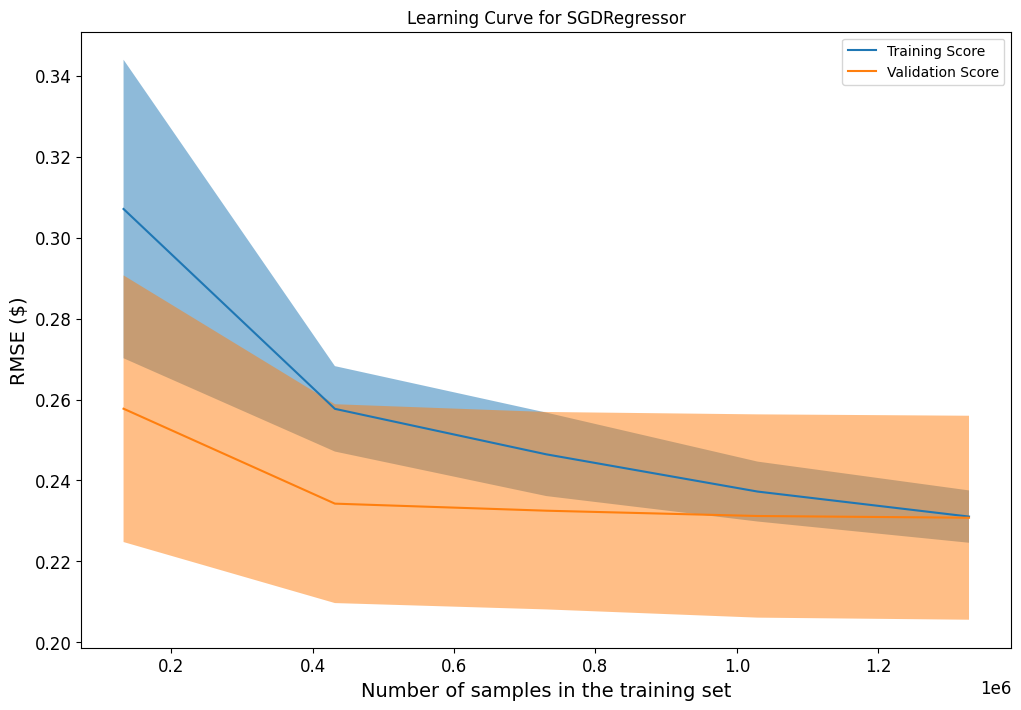

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import LearningCurveDisplay

# create an SGD regressor object
sgd_reg = SGDRegressor(
    loss="squared_error",
    max_iter=2000,
    penalty=None,
    eta0=0.0001,
    tol=1e-3,
)

# create an empty figure with an axis system
fig, ax = plt.subplots(figsize=(12, 8))

# generate the learning curves using the SGD regressor created above
LearningCurveDisplay.from_estimator(
    sgd_reg,
    X_train_final,
    y_train,
    scoring="neg_root_mean_squared_error", #  negated RMSE
    score_type="both", # show both training and validation RMSE
    negate_score=True, # need to negate as our scoring is "negated"
    score_name="RMSE ($)",
    n_jobs=-1,  # use all the CPU processors
    ax=ax # figure axis where the curves will be drawn
)

# personalize legend and figure title
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Validation Score"])
ax.set_title(f"Learning Curve for {sgd_reg.__class__.__name__}")
plt.show()

#### Observations from plot above 

* Training RMSE (blue) starts higher when the training set is small, then decreases steadily as more data is added. This is normal: with more samples, the model fits better.

* Validation RMSE (orange) also decreases as the training set grows, and it stays consistently below training RMSE. That means the model generalizes quite well.

* Both curves converge around ~0.23–0.24 RMSE. Small gap = low overfitting risk.

* The shaded regions (variance across folds) get narrower as the dataset size increases. More data more stable estimates.

**However** The fact that validation RMSE is slightly lower than training RMSE suggests that your model might be benefiting from regularization in SGD, which prevents overfitting or model fine-tuning hyperparameter.

We will try tuning hyperparameters (alpha, penalty, max_iter, learning_rate) to see if RMSE improves further.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

# create an SGD regressor object
sgd_reg = SGDRegressor(
    loss="squared_error",
    max_iter=1, # train only for one epoch at the time
    penalty=None,
    eta0=1e-4,
    tol=1,
    warm_start=True,
    learning_rate="constant" # the learning rate remains constant throughout training
)

min_val_error: float = float("inf") # positive infinity
best_epoch: int | None = None
best_model: SGDRegressor | None = None

n_epochs = 2000

train_errors = np.zeros(n_epochs)
val_errors = np.zeros(n_epochs)

# partition the training set into a smaller training and validation set. Assign 25% of the samples to validation
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_train_final, y_train, test_size=0.25, random_state=42
)

for epoch in range(2000):
    sgd_reg.fit(X_train_es, y_train_es) # as "warm_start" is true it will keep on training at each iteration - online learning
    # make prediction on the training set
    y_train_pred = sgd_reg.predict(X_train_es)
    # make predictions on the validation set
    y_val_pred = sgd_reg.predict(X_val_es)
    # compute the MSE on the training set
    train_error = mean_squared_error(y_train_es, y_train_pred)
    # compute the MSE on the validation set
    val_error = mean_squared_error(y_val_es, y_val_pred)
    # check if the the current validation error is smaller than the minimum validation error
    # if so update minimum validation error, best epoch and best model
    if val_error < min_val_error:
        min_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
    # set train and validation error for the current epoch
    train_errors[epoch] = train_error
    val_errors[epoch] = val_error


'\n# create an SGD regressor object\nsgd_reg = SGDRegressor(\n    loss="squared_error",\n    max_iter=1, # train only for one epoch at the time\n    penalty=None,\n    eta0=1e-4,\n    tol=1,\n    warm_start=True,\n    learning_rate="constant" # the learning rate remains constant throughout training\n)\n\nmin_val_error: float = float("inf") # positive infinity\nbest_epoch: int | None = None\nbest_model: SGDRegressor | None = None\n\nn_epochs = 2000\n\ntrain_errors = np.zeros(n_epochs)\nval_errors = np.zeros(n_epochs)\n\n# partition the training set into a smaller training and validation set. Assign 25% of the samples to validation\nX_train_es, X_val_es, y_train_es, y_val_es = train_test_split(\n    X_train_final, y_train, test_size=0.25, random_state=42\n)\n\nfor epoch in range(2000):\n    sgd_reg.fit(X_train_es, y_train_es) # as "warm_start" is true it will keep on training at each iteration - online learning\n    # make prediction on the training set\n    y_train_pred = sgd_reg.predic

Let's plot the training and validation errors:

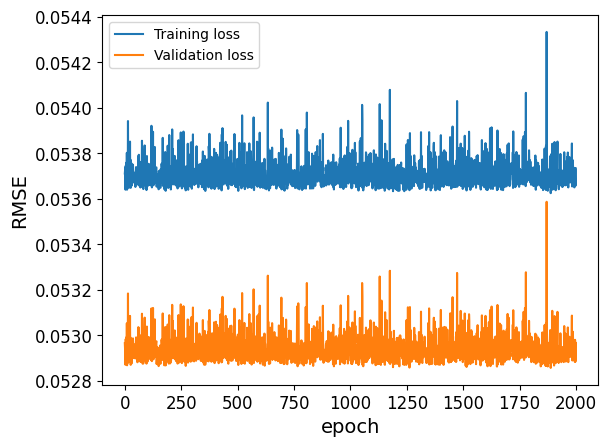

In [72]:
plt.plot(train_errors, label="Training loss")
plt.plot(val_errors, label="Validation loss")
plt.ylabel("RMSE")
plt.xlabel("epoch")
plt.legend()
plt.show()

No sign of underfitting or overfitting - The model has already converged 

In [73]:
best_epoch

1888

In [74]:
best_model

SGDRegressor(eta0=0.0001, learning_rate='constant', max_iter=1, penalty=None,
             tol=1, warm_start=True)

### Evaluate on test data

In [76]:
best_model.fit(X_train_final, y_train)

c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDRegressor(eta0=0.0001, learning_rate='constant', max_iter=1, penalty=None,
             tol=1, warm_start=True)

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Predict on test set
y_pred = best_model.predict(X_test_final)

# 2. Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

Test RMSE: 0.1773
Test MAE: 0.0840
Test R²: 0.9513


In [59]:
# y_pred_original = scaler_y.inverse_transform(y_pred)

In [85]:
import joblib

# Save the model
joblib.dump(best_model, "best_model.pkl")

['best_model.pkl']